In [1]:
import numpy as np
import pandas as pd

import pymysql
import dotenv
import os
import pickle
import seaborn as sns
import matplotlib

from datetime import timedelta

import matplotlib.pyplot as plt

# Normalization/Standardization
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Conv1D, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.saving import save_model

# 경고 무시 코드 추가
import warnings
warnings.filterwarnings('ignore')

def pltconfig_default() :
  sns.reset_defaults()
  %matplotlib inline

pltconfig_default()

matplotlib.rcParams

matplotlib.rcParams['font.family']

current_font_list = matplotlib.rcParams['font.family']

font_path = 'C:\\Windows\\Fonts\\batang.ttc'

kfont = matplotlib.font_manager.FontProperties(fname=font_path).get_name()

matplotlib.rcParams['font.family'] = [kfont] + current_font_list


In [2]:
# with open('StandardScalar_final_data', 'rb') as file :
#   St_NotEncode_data = pickle.load(file)

St_NotEncode_data = pd.read_pickle("StandardScalar_final_data")
  
print(St_NotEncode_data.shape)

(17422, 9)


In [3]:
# Feature와 Label 분리하기
def Feature_Label(datafile) :
    X = datafile.iloc[:,:-1]
    y = datafile.iloc[:,-1]

    return X, y

print("StandardScaler Not Encode Data")
SNE_X, SNE_y = Feature_Label(St_NotEncode_data)
print(SNE_X.shape, SNE_y.shape)
SNE_X_train, SNE_X_test, SNE_y_train, SNE_y_test = train_test_split(SNE_X, SNE_y, test_size=0.2, random_state=10, shuffle=False)
print(SNE_X_train.shape, SNE_X_test.shape, SNE_y_train.shape, SNE_y_test.shape)
print("=======================================")

StandardScaler Not Encode Data
(17422, 8) (17422,)
(13937, 8) (3485, 8) (13937,) (3485,)


<Axes: ylabel='8'>

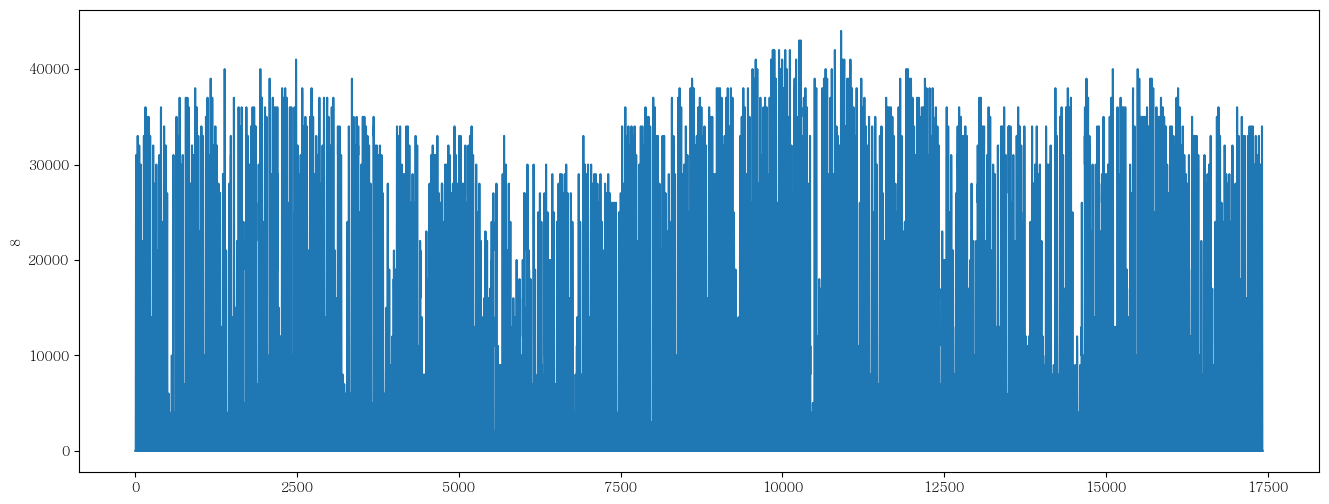

In [4]:
# fig, axe = plt.subplots(figsize=(16, 6), layout='constrained')
plt.figure(figsize=(16, 6))

sns.lineplot(y=SNE_y, x=SNE_X.index)

In [5]:
# SNE_X_train, SNE_X_test, SNE_y_train, SNE_y_test = train_test_split(SNE_X, SNE_y, test_size=0.2, random_state=10, shuffle=False)

# print(SNE_X_train.shape, SNE_y_train.shape)

In [6]:
#일변량 시계열 (발전량만을 활용한 시계열 데이터셋)

def windowed_dataset(series, window_size, batch_size, shuffle) :
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  # window_size : 몇 개의 데이터로 다음 데이터를 예측할지 설정, stride : 윈도우 데이터셋을 몇 칸씩 이동할지 결정, drop_remainder : 뒤에 잔여 데이터 미처리 적용(데이터셋 사이즈가 달라지는 것을 방지)
  ds = ds.window(window_size + 1, stride=1, shift=1, drop_remainder=True) # window_size + 1 : X(feature)와 y(target) 값을 포함하는 범위(즉 +1은 y(target) 포함을 의미)
  # flat_map : map 함수와 동일하게 맵핑을 해주지만 flat한 결과값을 준다!(즉, 차원 -1)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  if shuffle :
    ds = ds.shuffle(1000)
  ds = ds.map(lambda w : (w[:-1], w[-1])) # w[:-1] : 학습 데이터 , w[-1] : 예측 데이터
  # batch : 배치를 구성해주는 함수 / prefetch : 미리 데이터를 fetch하는 개수 (병렬 처리하므로 학습 속도 개선 효과)
  return ds.batch(batch_size).prefetch(1)

In [7]:
WINDOW_SIZE=3
BATCH_SIZE=32 # 한번에 여러 개의 데이터를 처리하는 병렬 처리 형태로 계산 효율을 높일 수 있다. 즉, 성능, 메모리 측면에서 유리 + 또한 가중치 업데이트 횟수를 제어할 수 있음

In [8]:
# train_data = windowed_dataset(SNE_y_train, WINDOW_SIZE, BATCH_SIZE, True) # 기존 적용
train_data = windowed_dataset(SNE_y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(SNE_y_test, WINDOW_SIZE, BATCH_SIZE, False)
train_data_ns = windowed_dataset(SNE_y_train, WINDOW_SIZE, BATCH_SIZE, False)

In [9]:
for data in train_data.take(1) :  # take : 1개의 배치만 가져오기
  print(f'{data[0].shape}')
  print(f'{data[1].shape}')

(32, 3, 1)
(32, 1)


In [10]:
# test_model = Sequential([
#   Conv1D(filters=32, kernel_size=30,
#          padding='causal', # 시계열 데이터와 같은 순차 데이터를 다룰 때 유용한 방법으로 입력 데이터 주변에 가상의 값을 추가하여 출력 크기를 조정하거나 경계 효과를 제어하는데 사용된다
#          activation='relu',
#          input_shape=[WINDOW_SIZE, 1]),
#   LSTM(256, recurrent_dropout=0.5, activation='tanh', return_sequences=True),  
#   # tanh함수는 출력 범위가 -1~1로 제한되며 양수와 음수를 모두 다룰 수 있음
#   # ReLU함수는 출력 범위가 0~1로 제한되며 음수의 경우 0으로 출력하여 음수값을 제거하는 효과가 있음, But, 음수를 처리하지 못해 그래디언트 소실 문제가 발생할 수 있음
#   LSTM(128, activation='tanh', return_sequences=True),
#   LSTM(64, activation='tanh', return_sequences=True),
#   LSTM(32, activation='tanh'),
#   Dense(8, activation='relu'),
#   # Dropout(0.5), # 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나로 학습 과정에서 일부 뉴런의 출력을 랜덤하게 0으로 만들어 모델의 일반화 능력을 향상시킨다
#   Dense(1)
# ])

In [11]:
# 현재까지 loss가 가장 낮은 모델

lstm_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal', # 시계열 데이터와 같은 순차 데이터를 다룰 때 유용한 방법으로 입력 데이터 주변에 가상의 값을 추가하여 출력 크기를 조정하거나 경계 효과를 제어하는데 사용된다
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  LSTM(128, activation='tanh', return_sequences=True),  
  # tanh함수는 출력 범위가 -1~1로 제한되며 양수와 음수를 모두 다룰 수 있음
  # ReLU함수는 출력 범위가 0~1로 제한되며 음수의 경우 0으로 출력하여 음수값을 제거하는 효과가 있음, But, 음수를 처리하지 못해 그래디언트 소실 문제가 발생할 수 있음
  LSTM(64, activation='tanh', return_sequences=True),
  LSTM(32, activation='tanh'),
  Dense(8, activation='relu'),
  # Dropout(0.5), # 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나로 학습 과정에서 일부 뉴런의 출력을 랜덤하게 0으로 만들어 모델의 일반화 능력을 향상시킨다
  Dense(1)
])

In [12]:
rnn_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal', # 시계열 데이터와 같은 순차 데이터를 다룰 때 유용한 방법으로 입력 데이터 주변에 가상의 값을 추가하여 출력 크기를 조정하거나 경계 효과를 제어하는데 사용된다
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  SimpleRNN(128, activation='tanh', return_sequences=True),  
  # tanh함수는 출력 범위가 -1~1로 제한되며 양수와 음수를 모두 다룰 수 있음
  # ReLU함수는 출력 범위가 0~1로 제한되며 음수의 경우 0으로 출력하여 음수값을 제거하는 효과가 있음, But, 음수를 처리하지 못해 그래디언트 소실 문제가 발생할 수 있음
  SimpleRNN(64, activation='tanh', return_sequences=True),
  SimpleRNN(32, activation='tanh'),
  Dense(8, activation='relu'),
  # Dropout(0.5), # 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나로 학습 과정에서 일부 뉴런의 출력을 랜덤하게 0으로 만들어 모델의 일반화 능력을 향상시킨다
  Dense(1)
])

In [13]:
gru_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal', # 시계열 데이터와 같은 순차 데이터를 다룰 때 유용한 방법으로 입력 데이터 주변에 가상의 값을 추가하여 출력 크기를 조정하거나 경계 효과를 제어하는데 사용된다
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  GRU(128, activation='tanh', return_sequences=True),  
  # tanh함수는 출력 범위가 -1~1로 제한되며 양수와 음수를 모두 다룰 수 있음
  # ReLU함수는 출력 범위가 0~1로 제한되며 음수의 경우 0으로 출력하여 음수값을 제거하는 효과가 있음, But, 음수를 처리하지 못해 그래디언트 소실 문제가 발생할 수 있음
  GRU(64, activation='tanh', return_sequences=True),
  GRU(32, activation='tanh'),
  Dense(8, activation='relu'),
  # Dropout(0.5), # 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나로 학습 과정에서 일부 뉴런의 출력을 랜덤하게 0으로 만들어 모델의 일반화 능력을 향상시킨다
  Dense(1)
])

In [14]:
loss = Huber() # MSE(Mean Squared Error)와 MAE(Mean Absolute Error)의 특성을 혼합한 것으로 이상치에 민감하지 않으면서도 큰 오차에 덜 민감한 특성을 가진다
optimizer = Adam(learning_rate=0.001) # 0.0005
lstm_model.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
rnn_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
gru_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
# test_model.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])

In [15]:
# ReduceLROnPlateau : 학습 도중 learning_rate를 동적으로 조정하는 데 사용된다 (에코크 동안 지정된 지표(monitor)에 대한 개선이 없는 경우 learning_rate를 감소시킨다)
# 주요 파라미터 : monitor - 모니터링할 지표(검증 손실(val_loss), val_rmse, val_mae 등), factor - 학습률을 감소시킬 비율, patience : 지정된 에포크 동안 개선이 없을 경우 학습률 감소, mode - 판단 방식('auto', #                          'min', 'max'), min_lr - learning_rate 하한값 지정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# EarlyStopping : 모델의 성능이 개선되지 않을 경우 학습을 조기 종료하여 불필요한 계산을 줄이고 과적합을 방지
# 주요 파라미터 : monitor - 모니터링할 지표, patience - 지정된 에포크 동안 개선이 없을 경우 종료, mode - 모니터링 지표의 개선 여부 판단 방식, verbose - EarlyStopping 동작 상황 출력 여부 지정
#                restore_best_weights - 적용 후 최적의 모델 가중치를 복원할지 여부를 지정                  
es = EarlyStopping(monitor='val_loss', patience=20)

# ModelCheckpoint : 학습 도중 지정된 지표(monitor) 기반하여 가장 성능이 좋은 모델 가중치를 저장 (지표가 개선되었을 때만 가중치 저장)
#                   filepath : 모델 가중치 저장 경로 지정 (`{epoch:02d}`와 같은 형식을 사용해 에포크 번호 등을 동적으로 포맷팅 가능), save_best_only - True 설정 시 가장 좋은 성능을 보인 모델 가중치만 저장

# mc = ModelCheckpoint('test_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_lstm = ModelCheckpoint('new_stne_lstm_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_lstm_ns = ModelCheckpoint('new_stne_lstm_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_rnn = ModelCheckpoint('new_stne_rnn_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_rnn_ns = ModelCheckpoint('new_stne_rnn_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_gru = ModelCheckpoint('new_stne_gru_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_gru_ns = ModelCheckpoint('new_stne_gru_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

# callback = [reduce_lr, es, mc]

In [16]:
# test_history = test_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=callback)

In [17]:
# loss : 모델이 훈련데이터에 대해 얼마나 잘 학습하고 있는지 평가하는 지표 (모델이 훈련데이터에 미치는 오차의 평균을 나타낸다)
# val_loss : 검증 데이터(validation data)에 대한 손실 값으로 검증 데이터를 사용해 모델의 일반화 성능을 평가한다 (즉, 훈련 데이터 외의 데이터에 대해서도 얼마나 잘 예측하는지를 판단)
# loss와 val_loss가 크지 않은 모델이 overfitting 되지 않고 이상적인 모델이다!

lstm_history = lstm_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_lstm])
lstm_history_ns = lstm_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_lstm_ns])

Epoch 1/500
    425/Unknown - 7s 4ms/step - loss: 7586.8765 - mse: 182972560.0000 - mae: 7587.1934
Epoch 1: val_loss improved from inf to 7088.14014, saving model to new_stne_lstm_weight.h5
436/436 [==============================] - 9s 10ms/step - loss: 7609.0605 - mse: 183259456.0000 - mae: 7609.3784 - val_loss: 7088.1401 - val_mse: 170736240.0000 - val_mae: 7088.4214 - lr: 0.0010
Epoch 2/500
425/436 [============================>.] - ETA: 0s - loss: 7543.8755 - mse: 181121888.0000 - mae: 7544.1777
Epoch 2: val_loss improved from 7088.14014 to 6996.43994, saving model to new_stne_lstm_weight.h5
436/436 [==============================] - 2s 5ms/step - loss: 7538.8042 - mse: 180702384.0000 - mae: 7539.1060 - val_loss: 6996.4399 - val_mse: 167513248.0000 - val_mae: 6996.7334 - lr: 0.0010
Epoch 3/500
434/436 [============================>.] - ETA: 0s - loss: 7406.6309 - mse: 176171968.0000 - mae: 7406.9360
Epoch 3: val_loss improved from 6996.43994 to 6854.73389, saving model to new_stne_

In [18]:
rnn_history = rnn_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_rnn])
rnn_history_ns = rnn_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_rnn_ns])

Epoch 1/500


    436/Unknown - 5s 3ms/step - loss: 7603.6187 - mse: 183063280.0000 - mae: 7603.9780
Epoch 1: val_loss improved from inf to 7071.09766, saving model to new_stne_rnn_weight.h5
436/436 [==============================] - 6s 5ms/step - loss: 7603.6187 - mse: 183063280.0000 - mae: 7603.9780 - val_loss: 7071.0977 - val_mse: 170232816.0000 - val_mae: 7071.5015 - lr: 0.0010
Epoch 2/500
432/436 [============================>.] - ETA: 0s - loss: 7501.5840 - mse: 179422336.0000 - mae: 7502.0303
Epoch 2: val_loss improved from 7071.09766 to 6941.60693, saving model to new_stne_rnn_weight.h5
436/436 [==============================] - 2s 4ms/step - loss: 7505.2988 - mse: 179493248.0000 - mae: 7505.7456 - val_loss: 6941.6069 - val_mse: 165693888.0000 - val_mae: 6942.0771 - lr: 0.0010
Epoch 3/500
423/436 [============================>.] - ETA: 0s - loss: 7295.5791 - mse: 172775232.0000 - mae: 7296.0640
Epoch 3: val_loss improved from 6941.60693 to 6732.31787, saving model to new_stne_rnn_weight.h5
4

In [19]:
gru_history = gru_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_gru])
gru_history_ns = gru_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_gru_ns])

Epoch 1/500


    435/Unknown - 12s 6ms/step - loss: 7615.9390 - mse: 183480832.0000 - mae: 7616.2651
Epoch 1: val_loss improved from inf to 7106.72412, saving model to new_stne_gru_weight.h5
436/436 [==============================] - 15s 12ms/step - loss: 7619.9600 - mse: 183658496.0000 - mae: 7620.2852 - val_loss: 7106.7241 - val_mse: 171538432.0000 - val_mae: 7107.0107 - lr: 0.0010
Epoch 2/500
430/436 [============================>.] - ETA: 0s - loss: 7563.5996 - mse: 181821344.0000 - mae: 7563.9058
Epoch 2: val_loss improved from 7106.72412 to 7043.36133, saving model to new_stne_gru_weight.h5
436/436 [==============================] - 3s 7ms/step - loss: 7576.6865 - mse: 182088352.0000 - mae: 7576.9932 - val_loss: 7043.3613 - val_mse: 169202864.0000 - val_mae: 7043.6621 - lr: 0.0010
Epoch 3/500
435/436 [============================>.] - ETA: 0s - loss: 7482.7051 - mse: 178742720.0000 - mae: 7483.0117
Epoch 3: val_loss improved from 7043.36133 to 6927.76514, saving model to new_stne_gru_weight.h

In [20]:
# 종합 결과

history_list = ["lstm_history", "rnn_history", "gru_history", "lstm_history_ns", "rnn_history_ns", "gru_history_ns"]
def result(historys) :
  for name, history in globals().items() :
    if name in history_list :
      print(f"-------------{name}-------------")
      val_loss = min(history.history['val_loss'])
      val_mse = min(history.history['val_mse'])
      val_mae = min(history.history['val_mae'])
      print(f"{name} Validation Loss:", val_loss)
      print(f"{name} Validation MSE:", val_mse)
      print(f"{name} Validation MAE:", val_mae)

result(history_list)

-------------lstm_history-------------
lstm_history Validation Loss: 2057.786865234375
lstm_history Validation MSE: 19070594.0
lstm_history Validation MAE: 2058.07666015625
-------------lstm_history_ns-------------
lstm_history_ns Validation Loss: 2069.00537109375
lstm_history_ns Validation MSE: 19343252.0
lstm_history_ns Validation MAE: 2069.289306640625
-------------rnn_history-------------
rnn_history Validation Loss: 2152.904296875
rnn_history Validation MSE: 20686086.0
rnn_history Validation MAE: 2153.19287109375
-------------rnn_history_ns-------------
rnn_history_ns Validation Loss: 2155.010009765625
rnn_history_ns Validation MSE: 20444336.0
rnn_history_ns Validation MAE: 2155.302490234375
-------------gru_history-------------
gru_history Validation Loss: 2150.065673828125
gru_history Validation MSE: 19680178.0
gru_history Validation MAE: 2150.363037109375
-------------gru_history_ns-------------
gru_history_ns Validation Loss: 1701.9912109375
gru_history_ns Validation MSE: 1220

In [21]:
lstm_save_path = f"./Models/lstm_model_stne_only"
rnn_save_path = f"./Models/rnn_model_stne_only"
gru_save_path = f"./Models/gru_model_stne_only"

save_model(lstm_model, lstm_save_path, overwrite=True)
save_model(rnn_model, rnn_save_path, overwrite=True)
save_model(gru_model, gru_save_path, overwrite=True)

INFO:tensorflow:Assets written to: ./Models/lstm_model_stne_only\assets


INFO:tensorflow:Assets written to: ./Models/lstm_model_stne_only\assets


INFO:tensorflow:Assets written to: ./Models/rnn_model_stne_only\assets


INFO:tensorflow:Assets written to: ./Models/rnn_model_stne_only\assets


INFO:tensorflow:Assets written to: ./Models/gru_model_stne_only\assets


INFO:tensorflow:Assets written to: ./Models/gru_model_stne_only\assets


In [22]:
St_NotEncode_Basic_data = pd.read_pickle("Basic_StandardScalar_final_data")
  
print(St_NotEncode_Basic_data.shape)

(52578, 9)


In [23]:
# Feature와 Label 분리하기
def Feature_Label(datafile) :
    X = datafile.iloc[:,:-1]
    y = datafile.iloc[:,-1]

    return X, y

print("StandardScaler Not Encode Basic Data")
SB_X, SB_y = Feature_Label(St_NotEncode_Basic_data)
print(SB_X.shape, SB_y.shape)
SB_X_train, SB_X_test, SB_y_train, SB_y_test = train_test_split(SB_X, SB_y, test_size=0.2, random_state=10, shuffle=False)
print(SB_X_train.shape, SB_X_test.shape, SB_y_train.shape, SB_y_test.shape)
print("=======================================")

StandardScaler Not Encode Basic Data
(52578, 8) (52578,)
(42062, 8) (10516, 8) (42062,) (10516,)


In [24]:
train_data = windowed_dataset(SB_y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(SB_y_test, WINDOW_SIZE, BATCH_SIZE, False)
train_data_ns = windowed_dataset(SB_y_train, WINDOW_SIZE, BATCH_SIZE, False)

In [25]:
for data in train_data.take(1) :
  print(f'{data[0].shape}')
  print(f'{data[1].shape}')

(32, 3, 1)
(32, 1)


In [26]:
lstm_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal',
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  LSTM(128, activation='tanh', return_sequences=True),  
  LSTM(64, activation='tanh', return_sequences=True),
  LSTM(32, activation='tanh'),
  Dense(8, activation='relu'),
  Dense(1)
])

In [27]:
rnn_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal', 
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  SimpleRNN(128, activation='tanh', return_sequences=True),  
  SimpleRNN(64, activation='tanh', return_sequences=True),
  SimpleRNN(32, activation='tanh'),
  Dense(8, activation='relu'),
  Dense(1)
])

In [28]:
gru_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal',
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  GRU(128, activation='tanh', return_sequences=True),  
  GRU(64, activation='tanh', return_sequences=True),
  GRU(32, activation='tanh'),
  Dense(8, activation='relu'),
  Dense(1)
])

In [29]:
loss = Huber()
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
rnn_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
gru_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mse', 'mae'])

In [30]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
            
es = EarlyStopping(monitor='val_loss', patience=20)

mc_lstm = ModelCheckpoint('base_stne_lstm_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_lstm_ns = ModelCheckpoint('base_stne_lstm_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_rnn = ModelCheckpoint('base_stne_rnn_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_rnn_ns = ModelCheckpoint('base_stne_rnn_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_gru = ModelCheckpoint('base_stne_gru_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_gru_ns = ModelCheckpoint('base_stne_gru_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

In [31]:
lstm_history = lstm_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_lstm])
lstm_history_ns = lstm_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_lstm_ns])

Epoch 1/500


   1311/Unknown - 36s 10ms/step - loss: 2.0998 - mse: 28.0403 - mae: 2.4257
Epoch 1: val_loss improved from inf to 1.89622, saving model to base_stne_lstm_weight.h5
1315/1315 [==============================] - 39s 12ms/step - loss: 2.0991 - mse: 28.0213 - mae: 2.4250 - val_loss: 1.8962 - val_mse: 15.1975 - val_mae: 2.2502 - lr: 0.0010
Epoch 2/500
1312/1315 [============================>.] - ETA: 0s - loss: 1.0017 - mse: 6.1665 - mae: 1.2983
Epoch 2: val_loss improved from 1.89622 to 1.53876, saving model to base_stne_lstm_weight.h5
1315/1315 [==============================] - 11s 9ms/step - loss: 1.0026 - mse: 6.1743 - mae: 1.2993 - val_loss: 1.5388 - val_mse: 11.2410 - val_mae: 1.9197 - lr: 0.0010
Epoch 3/500
1315/1315 [==============================] - ETA: 0s - loss: 0.9729 - mse: 5.9796 - mae: 1.2647
Epoch 3: val_loss improved from 1.53876 to 1.52194, saving model to base_stne_lstm_weight.h5
1315/1315 [==============================] - 11s 9ms/step - loss: 0.9729 - mse: 5.9796 - ma

In [32]:
rnn_history = rnn_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_rnn])
rnn_history_ns = rnn_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_rnn_ns])

Epoch 1/500


   1306/Unknown - 10s 4ms/step - loss: 2.1244 - mse: 27.4820 - mae: 2.4669
Epoch 1: val_loss improved from inf to 1.90630, saving model to base_stne_rnn_weight.h5
1315/1315 [==============================] - 11s 5ms/step - loss: 2.1210 - mse: 27.3790 - mae: 2.4636 - val_loss: 1.9063 - val_mse: 15.3951 - val_mae: 2.3099 - lr: 0.0010
Epoch 2/500
1303/1315 [============================>.] - ETA: 0s - loss: 1.0212 - mse: 6.3036 - mae: 1.3363
Epoch 2: val_loss improved from 1.90630 to 1.88747, saving model to base_stne_rnn_weight.h5
1315/1315 [==============================] - 6s 5ms/step - loss: 1.0238 - mse: 6.3458 - mae: 1.3389 - val_loss: 1.8875 - val_mse: 15.2383 - val_mae: 2.2271 - lr: 0.0010
Epoch 3/500
1304/1315 [============================>.] - ETA: 0s - loss: 0.9927 - mse: 6.1130 - mae: 1.2985
Epoch 3: val_loss improved from 1.88747 to 1.65241, saving model to base_stne_rnn_weight.h5
1315/1315 [==============================] - 5s 4ms/step - loss: 0.9967 - mse: 6.1504 - mae: 1.30

In [33]:
gru_history = gru_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_gru])
gru_history_ns = gru_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_gru_ns])

Epoch 1/500


   1313/Unknown - 19s 7ms/step - loss: 1.6432 - mse: 17.3789 - mae: 1.9600
Epoch 1: val_loss improved from inf to 2.15691, saving model to base_stne_gru_weight.h5
1315/1315 [==============================] - 23s 10ms/step - loss: 1.6430 - mse: 17.3735 - mae: 1.9597 - val_loss: 2.1569 - val_mse: 18.5380 - val_mae: 2.4811 - lr: 0.0010
Epoch 2/500
1309/1315 [============================>.] - ETA: 0s - loss: 1.0061 - mse: 6.2016 - mae: 1.3052
Epoch 2: val_loss improved from 2.15691 to 1.50120, saving model to base_stne_gru_weight.h5
1315/1315 [==============================] - 11s 8ms/step - loss: 1.0072 - mse: 6.2121 - mae: 1.3065 - val_loss: 1.5012 - val_mse: 10.8621 - val_mae: 1.8479 - lr: 0.0010
Epoch 3/500
1313/1315 [============================>.] - ETA: 0s - loss: 0.9779 - mse: 6.0502 - mae: 1.2711
Epoch 3: val_loss improved from 1.50120 to 1.45537, saving model to base_stne_gru_weight.h5
1315/1315 [==============================] - 13s 10ms/step - loss: 0.9780 - mse: 6.0507 - mae: 

In [34]:
# 종합 결과

history_list = ["lstm_history", "rnn_history", "gru_history", "lstm_history_ns", "rnn_history_ns", "gru_history_ns"]
def result(historys) :
  for name, history in globals().items() :
    if name in history_list :
      print(f"-------------{name}-------------")
      val_loss = min(history.history['val_loss'])
      val_mse = min(history.history['val_mse'])
      val_mae = min(history.history['val_mae'])
      print(f"{name} Validation Loss:", val_loss)
      print(f"{name} Validation MSE:", val_mse)
      print(f"{name} Validation MAE:", val_mae)

result(history_list)

-------------lstm_history-------------
lstm_history Validation Loss: 1.2900581359863281
lstm_history Validation MSE: 9.1972017288208
lstm_history Validation MAE: 1.600001335144043
-------------lstm_history_ns-------------
lstm_history_ns Validation Loss: 1.2993721961975098
lstm_history_ns Validation MSE: 9.25202465057373
lstm_history_ns Validation MAE: 1.6082416772842407
-------------rnn_history-------------
rnn_history Validation Loss: 1.351880669593811
rnn_history Validation MSE: 9.608440399169922
rnn_history Validation MAE: 1.667106032371521
-------------rnn_history_ns-------------
rnn_history_ns Validation Loss: 1.3496030569076538
rnn_history_ns Validation MSE: 9.616933822631836
rnn_history_ns Validation MAE: 1.6675586700439453
-------------gru_history-------------
gru_history Validation Loss: 1.3690770864486694
gru_history Validation MSE: 9.89048957824707
gru_history Validation MAE: 1.6785365343093872
-------------gru_history_ns-------------
gru_history_ns Validation Loss: 1.33936

In [35]:
lstm_save_path = f"./Models/lstm_model_stne_base_only"
rnn_save_path = f"./Models/rnn_model_stne_base_only"
gru_save_path = f"./Models/gru_model_stne_base_only"

save_model(lstm_model, lstm_save_path, overwrite=True)
save_model(rnn_model, rnn_save_path, overwrite=True)
save_model(gru_model, gru_save_path, overwrite=True)

INFO:tensorflow:Assets written to: ./Models/lstm_model_stne_base_only\assets


INFO:tensorflow:Assets written to: ./Models/lstm_model_stne_base_only\assets


INFO:tensorflow:Assets written to: ./Models/rnn_model_stne_base_only\assets


INFO:tensorflow:Assets written to: ./Models/rnn_model_stne_base_only\assets


INFO:tensorflow:Assets written to: ./Models/gru_model_stne_base_only\assets


INFO:tensorflow:Assets written to: ./Models/gru_model_stne_base_only\assets


In [36]:
# 모델 불러오기 테스트

# load_path = f"./Models/lstm_model"
# loaded_model = load_model(load_path)

In [37]:
# weights = loaded_model.get_weights()

# for i, weight in enumerate(weights) :
#   print(f"Weight {i} :")
#   print(weight)
#   print("------------------")